# Analysis of f$_{NL}$ with DESI LRGs

This notebook will include snippets regarding the fNL project with DESI Imaging.

In [5]:
!qstat -u medirz90


o0003.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
21541758             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:04


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import modules as md

In [9]:
%matplotlib inline

In [10]:
md.dv.setup_color()

## Create C_ell for mocks with fNL != 0
Create cosmologies with fNL to test the pipeline

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

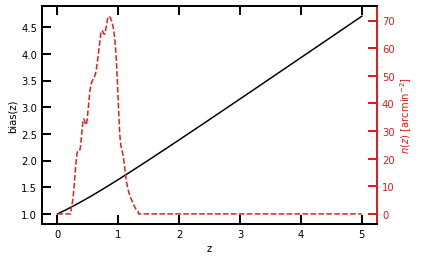

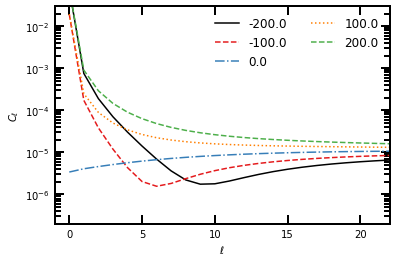

In [5]:
md.create_cl()

## Cleaned data
First we prepare the data into `hpix`, `features`, `label`, and `fracgood`.

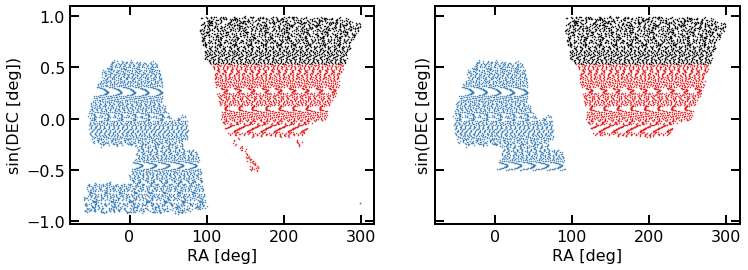

In [6]:
md.plot_radec()

## Target Density

798.8351667806639


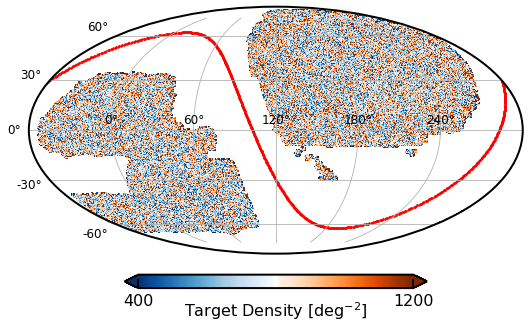

In [6]:
md.plot_ngal()

## Selection Functions

In [7]:
# everything
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecals_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecals_256_known1/nn-weights.fits']
md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits


/tmp/slurmtmp.20925985/ipykernel_4234/674072037.py:66: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts


In [6]:
# w dec cuts
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known1/nn-weights.fits']

md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits


/tmp/slurmtmp.20900451/ipykernel_10669/3419441414.py:10: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


In [6]:
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known2/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known2/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known2/nn-weights.fits']
#print(maps)
md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known2.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known2.hp256.fits


/tmp/slurmtmp.20934454/ipykernel_30948/674072037.py:66: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


In [5]:
# w dec cuts & two extra maps
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalscext_256_known1ext/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalscext_256_known1ext/nn-weights.fits']

md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1ext.hp256.fits')

/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:81: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1ext.hp256.fits


In [7]:
# known1 with imaging cuts
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzlsl_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalscl_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalscl_256_known1/nn-weights.fits']
md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desicl_known1.hp256.fits')

wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desicl_known1.hp256.fits


/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:81: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


In [7]:
# known1 with fracgood cuts
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzlsf_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalscf_256_known1/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalscf_256_known1/nn-weights.fits']
md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desicf_known1.hp256.fits')

/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:81: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desicf_known1.hp256.fits


In [13]:
# all+nstar
maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_allp/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_allp/nn-weights.fits',
        '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_allp/nn-weights.fits']
md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_allp.hp256.fits')

/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:81: RuntimeWarning: invalid value encountered in true_divide
  hpmap = hpmap / counts
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


wrote /fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_allp.hp256.fits


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
[762.85281187 882.96767244]
[768.70877619 872.53061009]
[765.42592846 876.23243794]
[760.62626899 884.85135114]


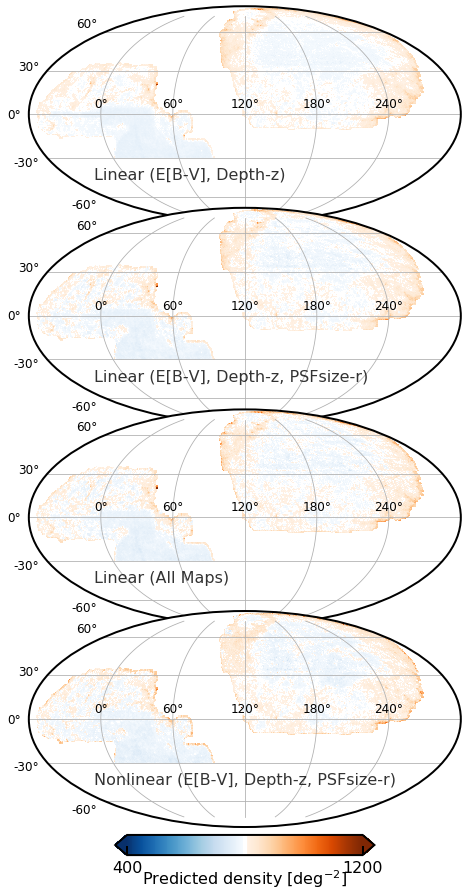

In [8]:
md.plot_npred()

Pearson Correlation Coefficient

100


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


bmzls done
100
ndecalsc done
100
sdecalsc done
(100, 9) 9
(100, 9) 9
(100, 9) 9


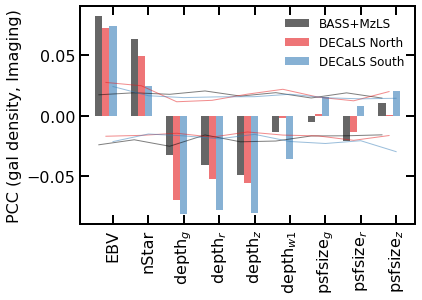

In [11]:
md.plot_pcc()

Pearson Correlation Coefficient

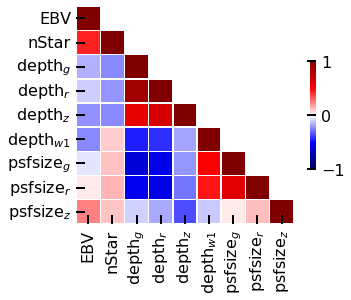

In [12]:
md.plot_corrmax()

## Cross Power

ell edges: [ 2  4  6  8 10 12 14 16 18 20]
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
nmocks: 1000, nbins: 81
nmocks: 1000, nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81


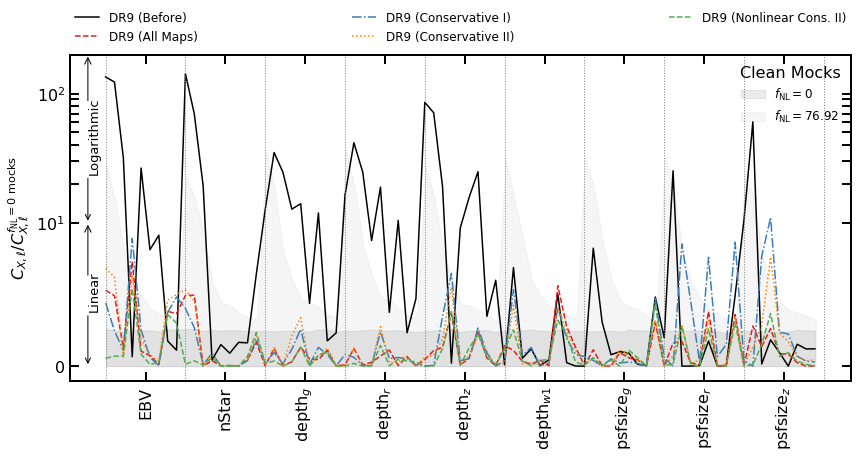

452.51439036526654 12.73599146545597
532.0629408864258 16.211484375059015


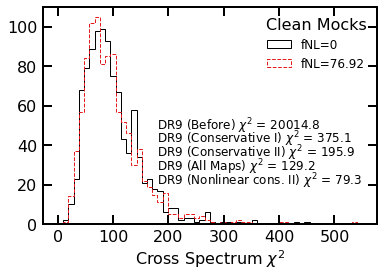

In [6]:
md.plot_clxtest()

## Test of mean density contrast

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

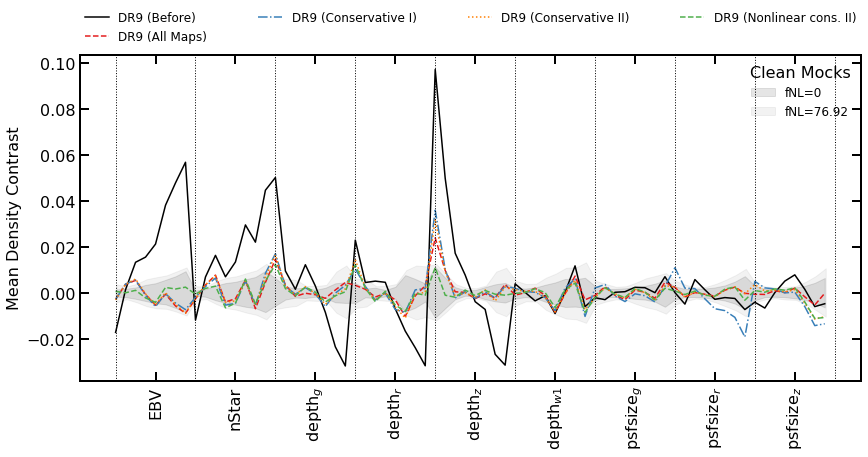

nmocks: 1000, nbins: 72
nmocks: 1000, nbins: 72
125.73479275585461 37.64838882795117
119.05340053084848 39.279522675915686


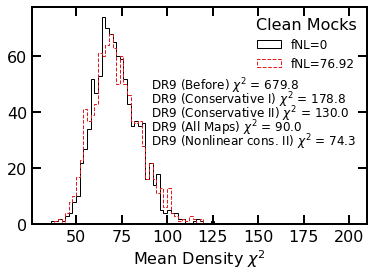

In [7]:
md.plot_nbartest()

## Bin C$_{\ell}$

In [6]:

for region in ['ndecals', 'sdecals', 'bmzls', 
               'ndecalsc', 'sdecalsc', 'desic',
               'bmzlsl', 'ndecalscl', 'sdecalscl', 'desicl',
               'bmzlsf', 'ndecalscf', 'sdecalscf', 'desicf']:
    md.bin_clmock('zero', region, '0', 'noweight', md.ut.ell_edges, log=True)
    if region == 'desic':
        md.bin_clmock('po100', region, '0', 'noweight', md.ut.ell_edges, log=True)   

[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero bmzlsf 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_296_lrg_zero_bmzlsf_256_noweight.npy
1000 768 37
going to do log transform
Hartlap with #mocks (1000) and #bins (37): 1.04
wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_zero_bmzlsf_256_noweight_mean.npz /fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_zero_bmzlsf_256_noweight_cov.npz
[  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]
zero ndecalscf 0 noweight
1000 /fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_765_lrg_zero_ndecalscf_256_noweight.npy
1000 768 37
going to do log transform
Hartlap with #mocks (1000) and #bins (37): 1.04
wrote /fs/ess/PHS0336/data/lognormal/v3/clustering/logclmock_0_lrg_zero_ndeca

## Histogram of C$_{\ell}$ vs log(C$_{\ell}$)

bins [  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]


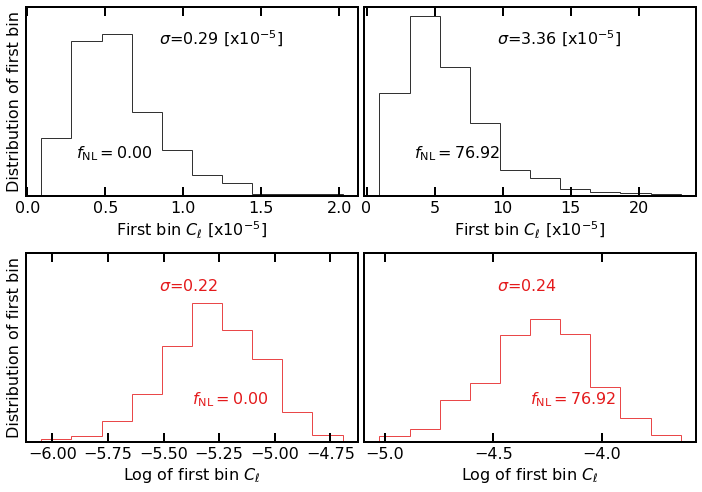

In [7]:
md.plot_clhist()

## Fitting $f_{\rm NL}$

### Best fit

-5.656438116009658
13.430539026178407


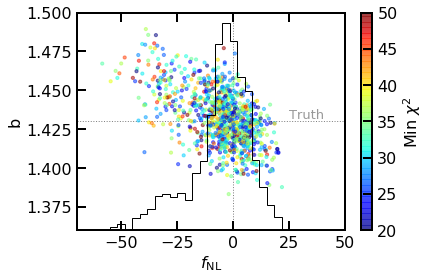

73.63068685515955
14.924500590722802


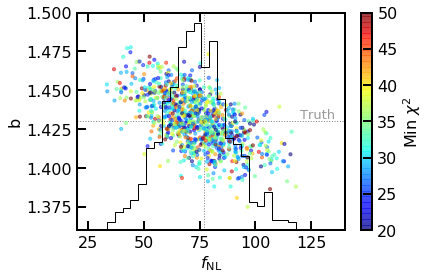

In [42]:
md.plot_bestfit()

### MCMC Contours

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


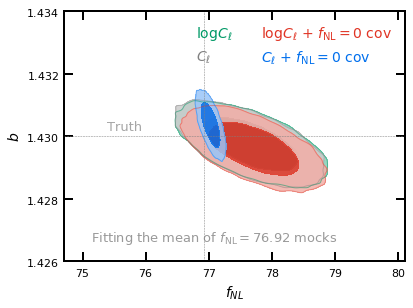

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
$76.92$ & DESI & log$C_{\ell}$          & $ 77.67$& $ 77.67$& $ 77.17<\fnl< 78.16$& $ 76.71<\fnl< 78.64$ &   38.8\\
$76.92$ & DESI & $C_{\ell}$             & $ 77.67$& $ 77.65$& $ 77.17<\fnl< 78.14$& $ 76.70<\fnl< 78.60$ &   39.0\\
$76.92$ & DESI & log$C_{\ell}$ + $f_{\rm NL}=0$ cov & $ 77.70$& $ 77.71$& $ 77.25<\fnl< 78.17$& $ 76.81<\fnl< 78.63$ &   39.9\\
$76.92$ & DESI & $C_{\ell}$ + $f_{\rm NL}=0$ cov & $ 77.03$& $ 77.02$& $ 76.93<\fnl< 77.12$& $ 76.83<\fnl< 77.22$ &  207.6\\
$0$ & DESI         &  log$C_{\ell}$     & $  0.36$& $  0.36$& $  0.06<\fnl<  0.65$& $ -0.23<\fnl<  0.94$ &   35.7\\
$0$ & DECaLS North &  log$C_{\ell}$     & $  0.07$& $  0.06$& $ -0.47<\fnl<  0.60$& $ -1.00<\fnl<  1.12$ &   26.7\\
$0$ & DECaLS South &  log$C_{\ell}$     & $  0.67$& $  0.67$& $  0.13<\fnl<  1.22$& $ -0.40<\fnl<  1.75$ &   34.3\\
$0$ & BASS+MzLS    &  log$C_{\ell}$     & $  0.83$& $  0.82$& $  0.25<\fnl<  1.40$& $ -0.31

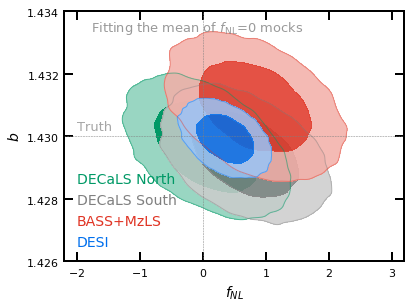

In [8]:
stats = md.plot_mcmc_mocks()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


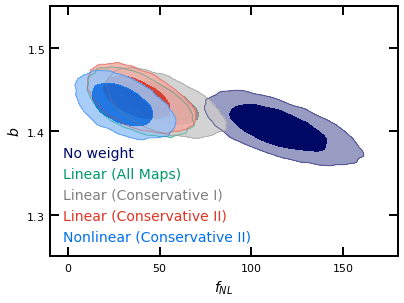

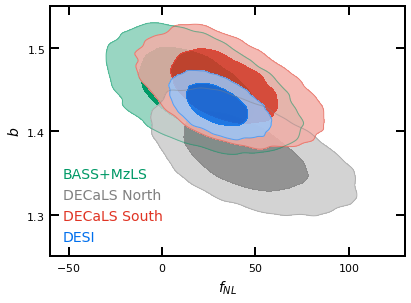

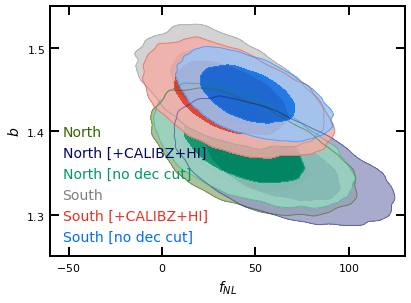

DESI                      & No Weight   & $113.18$& $115.49$& $ 98.14<\fnl<132.89$& $ 83.51<\fnl<151.59$ &   44.4\\
DESI                      & Linear (All Maps)& $ 36.05$& $ 37.72$& $ 26.13<\fnl< 49.21$& $ 16.31<\fnl< 62.31$ &   41.1\\
DESI                      & Linear (Conservative I)& $ 49.58$& $ 51.30$& $ 38.21<\fnl< 64.33$& $ 27.41<\fnl< 78.91$ &   38.8\\
DESI                      & Linear (Conservative II)& $ 36.63$& $ 38.11$& $ 26.32<\fnl< 49.86$& $ 16.36<\fnl< 63.12$ &   39.6\\
DESI                      & Nonlinear (Conservative II)& $ 28.58$& $ 29.79$& $ 18.91<\fnl< 40.59$& $  9.47<\fnl< 52.73$ &   34.6\\
DESI (imag. cut)          & Nonlinear (Conservative II)& $ 29.16$& $ 30.57$& $ 19.05<\fnl< 42.18$& $  9.01<\fnl< 54.81$ &   35.8\\
DESI (comp. cut)          & Nonlinear (Conservative II)& $ 28.07$& $ 29.48$& $ 18.38<\fnl< 40.50$& $  8.81<\fnl< 53.10$ &   34.5\\
DESI         & Nonlinear (Conservative II)+fNL=100 Cov& $ 31.62$& $ 33.11$& $ 20.94<\fnl< 45.24$& $ 10.56<\fnl< 59.

In [8]:
md.plot_mcmc_data()

28.57684133162572 37.14989373111344


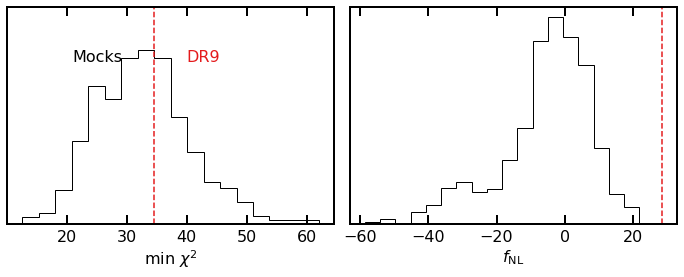

In [12]:
md.plot_dr9vsmocks()

In [75]:
md.ut.ell_edges.size-1 # num of data points: 37, dof = 37 - 1 - 3 = 33

37

## Model vs Observations

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

0.4726753555706283 1.4299247130148807


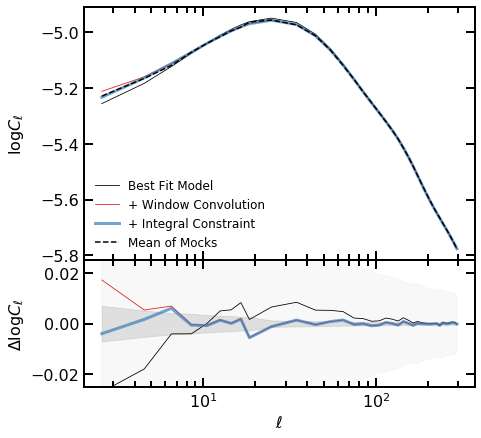

In [76]:
md.plot_model('zero')

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

All Maps 36.05310065845671 1.436296182456702
Conservative I 49.58384648962971 1.4351518629674762
Conservative II 36.633206055833334 1.440345736458642
Nonlinear (Cons. II) 28.57684133162572 1.4322088642875044


/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:941: RuntimeWarning: divide by zero encountered in log10
  cl_bf = np.log10(model(el_g, fnl=fnl, b=b, noise=noise))
/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:941: RuntimeWarning: divide by zero encountered in log10
  cl_bf = np.log10(model(el_g, fnl=fnl, b=b, noise=noise))
/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:941: RuntimeWarning: divide by zero encountered in log10
  cl_bf = np.log10(model(el_g, fnl=fnl, b=b, noise=noise))
/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:941: RuntimeWarning: divide by zero encountered in log10
  cl_bf = np.log10(model(el_g, fnl=fnl, b=b, noise=noise))


No weight 113.17500763020482 1.404533099226912


/users/PHS0336/medirz90/github/LSSutils/analysis/desi/notebooks/modules.py:941: RuntimeWarning: divide by zero encountered in log10
  cl_bf = np.log10(model(el_g, fnl=fnl, b=b, noise=noise))


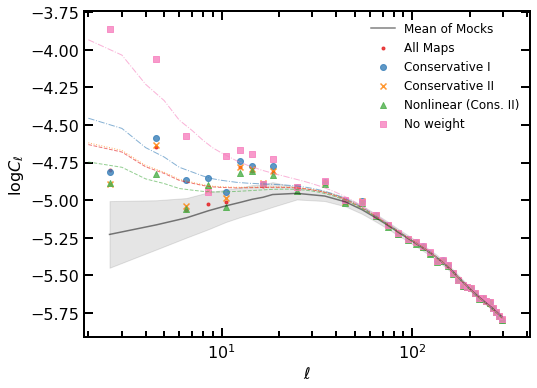

In [9]:
md.plot_dr9cl()

## f$_{\rm NL}$ vs $\ell_{\rm min}$

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

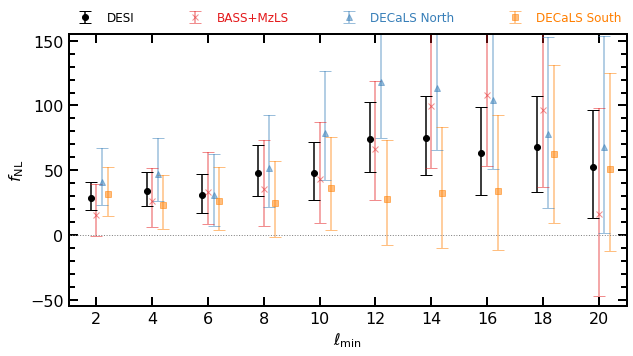

In [13]:
md.plot_fnl_lmin()

## ANYTHING BELOW IS FOR TESTING NEW IDEAS

In [1]:
import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
import fitsio as ft
import numpy as np
import healpy as hp
from lssutils.theory.cell import (init_sample, SurveySpectrum, Spectrum, bias_model_lrg)
import matplotlib.pyplot as plt

In [2]:
# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desic_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = dt['fracgood']
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

In [3]:
bestp = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/logmcmc_lrg_zero_desic_dnnp_known1_steps10k_walkers50_elmin0.npz')
fnl, b0, noise = bestp['best_fit']
print(fnl, b0, mask.mean())

37.14989373111344 1.4322088642875044 0.3958549499511719


In [4]:
def call(z, b, dNdz):
    model = SurveySpectrum()
    model.add_tracer(z, b, dNdz, p=1.0)
    model.add_kernels(model.el_model)
    model.add_window(weight, mask, np.arange(2048), ngauss=2048)

    res = []
    for fnl_ in [fnl, 0, 1.5*fnl]:
        print(fnl_)
        res.append(model(np.arange(500), fnl_, b0, noise))

    return res

def treat_noz(z, dNdz, kind=1, zl=23, zh=132):
    
    nz_low = lambda x:(x/z[zl])**kind*dNdz[zl]
    nz_high = lambda x:np.exp(-1.*(x-z[zh])*kind)*dNdz[zh]
    dNdz_ = dNdz.copy()
    dNdz_[:zl+1] = nz_low(z[:zl+1])
    dNdz_[zh:] = nz_high(z[zh:])
    return dNdz_

In [7]:
z, b, dNdz = init_sample('lrg')

In [8]:
dNdz8 = treat_noz(z, dNdz, kind=8, zl=25, zh=132)
dNdz4 = treat_noz(z, dNdz, kind=4, zl=24, zh=132)

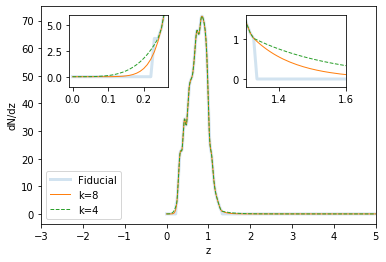

In [30]:
fg, ax = plt.subplots(figsize=(6, 4))

def plot(ax):
    ax.plot(z, dNdz, label='Fiducial', lw=3, alpha=0.2)
    ax.plot(z, dNdz8, label='k=8', lw=1,)
    ax.plot(z, dNdz4, label='k=4', lw=1, ls='--')

plot(ax)
ax.set(xlim=(-3, 5), xlabel='z', ylabel='dN/dz')
ax.legend(loc=3)

ax1 = fg.add_axes([0.19, 0.6, 0.23, 0.25])
plot(ax1)
ax1.set(xlim=(-0.01, 0.27), ylim=(-1, 6))


ax2 = fg.add_axes([0.6, 0.6, 0.23, 0.25])
plot(ax2)
ax2.set(xlim=(1.3, 1.6), ylim=(-0.2, 1.6))

fg.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/nztreat.pdf', bbox_inches='tight')

In [23]:
cl_fid = call(z, b, dNdz)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

37.14989373111344
0
55.724840596670155


In [24]:
cl_8 = call(z, b, dNdz8)
cl_4 = call(z, b, dNdz4)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0
37.14989373111344
0
55.724840596670155
h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0
37.14989373111344
0
55.724840596670155


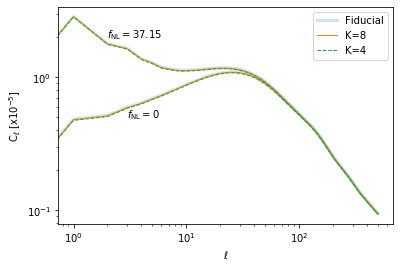

In [40]:
ls = ['-', '-', '--']
lw = [3, 1, 1]
al = [0.2, 1., 1.]

for i, (cl_i, ni) in enumerate(zip([cl_fid, cl_8, cl_4],
                                  ['Fiducial', 'K=8', 'K=4'])):
    plt.plot(1.0e5*cl_i[0], color='C%d'%i, ls=ls[i], lw=lw[i], alpha=al[i], label=ni)
    plt.plot(1.0e5*cl_i[1], color='C%d'%i, ls=ls[i], lw=lw[i], alpha=al[i])
    #plt.plot(1.0e5*cl_i[2], color='C%d'%i, ls=ls[i], lw=lw[i], alpha=al[i])
# plt.xlim(-1., 20)
plt.ylabel(r'C$_{\ell}$ [x$10^{-5}$]')
plt.xlabel(r'$\ell$')
plt.legend()
plt.loglog()

plt.text(2, 2, r'$f_{\rm NL}=37.15$')
plt.text(3., 0.5, r'$f_{\rm NL}=0$')

fg.savefig(f'/users/PHS0336/medirz90/github/dimagfnl/figures/cell_nz.pdf', bbox_inches='tight')

(1e-08, 0.0001)

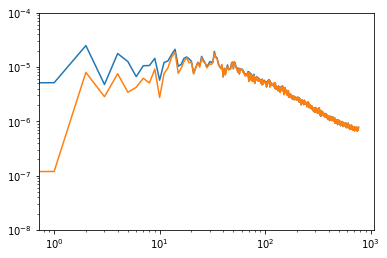

In [42]:
for r in ['known1', 'allp']:
    d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_dnnp_{r}.npy', allow_pickle=True).item()
    plt.loglog(d['cl_gg']['cl'])
plt.ylim(1.0e-8, 1.0e-4)

0.0003574434308084387
0.5000633597010058
0.0003574434308084387
0.5000633597010058
0.00011914781026947957
0.5000633597010058


(1e-08, 0.0001)

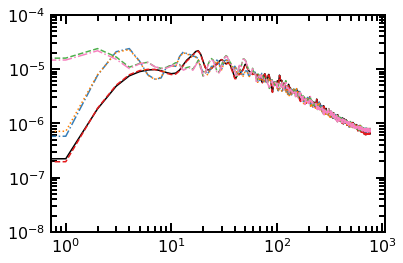

In [11]:
for r in ['bmzls', 'bmzlsf', 'ndecalsc', 'ndecalscf', 'sdecalsc', 'sdecalscf']:
    m = md.ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    print(m['fracgood'].min())
    d = md.np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_{r}_256_dnnp_known1.npy', allow_pickle=True).item()
    md.plt.loglog(d['cl_gg']['cl'])
md.plt.ylim(1.0e-8, 1.0e-4)

Text(0, 0.5, 'Normalized Distribution')

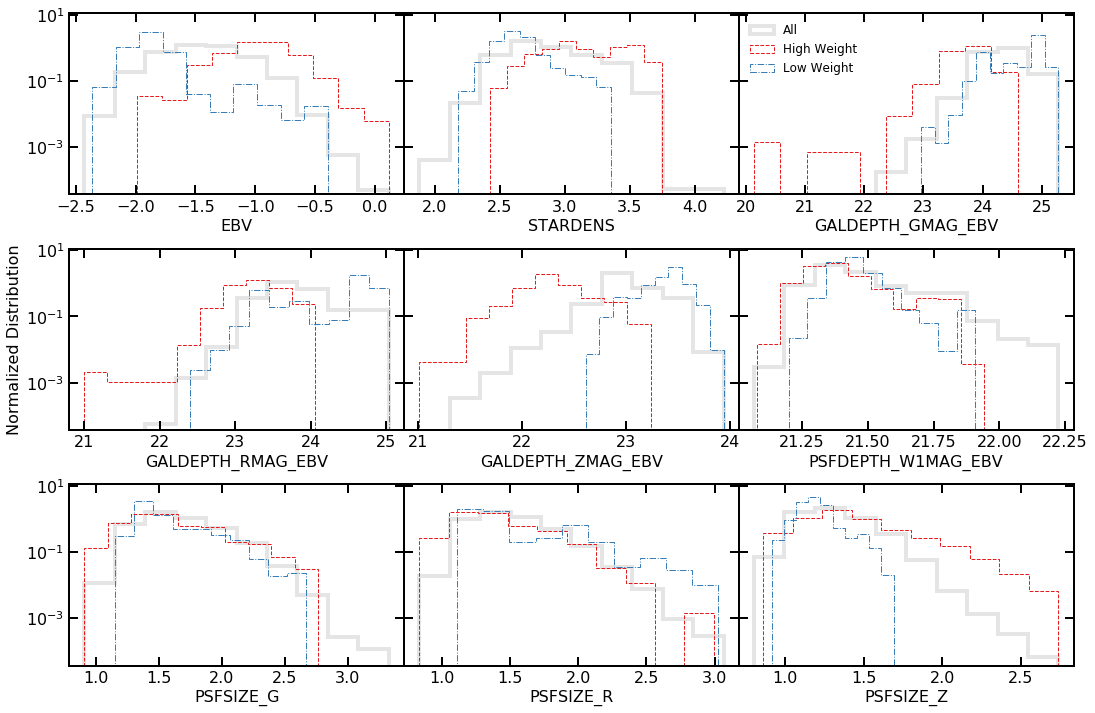

In [55]:
fig, ax = md.plt.subplots(nrows=3, ncols=3, figsize=(18, 12), sharey=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.3)

for i in range(9):

    yl = d['features'][is_low, i]
    yh = d['features'][is_high, i]
    yt = d['features'][:, i]
    
    if i < 2:
        yl = md.np.log10(yl)
        yh = md.np.log10(yh)
        yt = md.np.log10(yt)

    ax[i].hist(yt, histtype='step', label='All', density=True, lw=4, alpha=0.1)        
    ax[i].hist(yh, histtype='step', label='High Weight', density=True)
    ax[i].hist(yl, histtype='step', label='Low Weight', density=True)    


    ax[i].set(xlabel=md.ut.maps_dr9[i], yscale='log')
    
# md.plt.yscale('log')
ax[2].legend()
ax[3].set_ylabel('Normalized Distribution')

### fitting using all depth maps 

Text(0, 0.5, '$C_{\\ell}$')

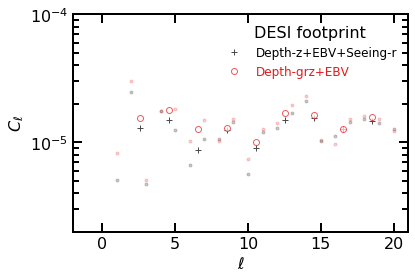

In [48]:
marker = ['+', 'o']
names = ['Depth-z+EBV+Seeing-r', 
        'Depth-grz+EBV']

for i, k in enumerate(['known1', 'known2']):
    cl = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_dnnp_{k}.npy', allow_pickle=True).item()
    ln, = plt.plot(cl['cl_gg']['cl'], marker='.', ls='None', alpha=0.2)
    
    lb, clb = ut.histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=ut.ell_edges)
    plt.plot(lb, clb, color=ln.get_color(), marker=marker[i], mfc='w', ls='', label=names[i], alpha=0.7)
    
plt.ylim(2.0e-6, 1.0e-4)    
plt.xlim(-2, 21)
plt.yscale('log')
lgn = plt.legend(title='DESI footprint')
for i, a in enumerate(lgn.get_texts()):
    a.set_color('C%i'%i)
    
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [5]:
import fitsio as ft
import lssutils.utils as ut
from lssutils.stats.nnbar import get_meandensity
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from lssutils.extrn.galactic.hpmaps import logHI

In [6]:
md.dv.setup_color()

In [74]:
def rotate(map1, mask1):
    map1[mask1] = np.nan
    map1_ = hp.reorder(map1, n2r=True)
    return map1_


def add_extras(reg):
    
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{reg}_256.fits')
    extra = ft.read('/fs/ess/PHS0336/data/templates/pixweight_external.fits')
    lh = logHI(path='/fs/ess/PHS0336/data/templates/NHI_HPX.fits')
    
    calibz = rotate(extra['CALIBZ'], extra['CALIBMASKZ']>0.5)
    #halpha = np.log10(rotate(extra['HALPHA'], extra['HALPHAMASK']==1))

    is_bad = np.isnan(calibz[data['hpix']])
    print('# bad', is_bad.sum())
    cmean = np.nanmean(calibz[data['hpix']])
    print(calibz[data['hpix']][is_bad])
    calibz[data['hpix'][is_bad]] = cmean
    print(cmean)
    print(calibz[data['hpix']][is_bad])
    sysm = np.column_stack([data['features'], calibz[data['hpix']], lh.map[data['hpix']]]) # halpha[data['hpix']]

    is_good = np.isnan(sysm).sum(axis=1) < 0.5
    assert(is_good.mean() ==1)

    data_new = ut.to_numpy(data['label'], sysm, data['fracgood'], data['hpix'])
    output = f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{reg}ext_256.fits'
    ft.write(output, data_new)
    print('wrote ', output)

In [76]:
add_extras('sdecalsc')

# bad 17
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
0.000637310640056521
[0.00063731 0.00063731 0.00063731 0.00063731 0.00063731 0.00063731
 0.00063731 0.00063731 0.00063731 0.00063731 0.00063731 0.00063731
 0.00063731 0.00063731 0.00063731 0.00063731 0.00063731]
wrote  /fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_sdecalscext_256.fits


In [77]:
add_extras('ndecalsc')

# bad 9
[nan nan nan nan nan nan nan nan nan]
0.0004601287371009316
[0.00046013 0.00046013 0.00046013 0.00046013 0.00046013 0.00046013
 0.00046013 0.00046013 0.00046013]
wrote  /fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecalscext_256.fits


In [31]:
def run_calib_test(reg):
    names = [r'EBV', r'nStar']+[fr'depth$_{b}$' for b in ['g', 'r', 'z', '{w1}']]\
            + [fr'psfsize$_{b}$' for b in ['g', 'r', 'z']]    +  [ 'CALIBZ', 'logHI'] # 'logHalpha',    
    
    print(reg)
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{reg}_256.fits')
    extra = ft.read('/fs/ess/PHS0336/data/templates/pixweight_external.fits')
    wnn = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits')
    nmock = hp.read_map('/fs/ess/PHS0336/data/lognormal/v3/hpmaps/lrghp-zero-123-f1z1.fits')


    calibz = rotate(extra['CALIBZ'], extra['CALIBMASKZ']>0.5)
    #halpha = np.log10(rotate(extra['HALPHA'], extra['HALPHAMASK']==1))
    sysm = np.column_stack([data['features'], calibz[data['hpix']], lh.map[data['hpix']]]) # halpha[data['hpix']]

    hp.mollview(calibz, min=-0.002, max=0.002)
    #hp.mollview(halpha, rot=120)

    is_good = np.isnan(sysm).sum(axis=1) < 0.5
    all_good = np.ones(data.size, '?')
    print(is_good.mean())

    nnbar_before = get_meandensity(data['label'], data['fracgood'], is_good, sysm)
    nnbar_after = get_meandensity(data['label'], data['fracgood'],  is_good, sysm, selection_fn=wnn[data['hpix']])
    nnbar_mock = get_meandensity(nmock[data['hpix']], np.ones(data.size), is_good, sysm)

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 15), sharey=True)
    fig.subplots_adjust(hspace=0.2, wspace=0.0)

    ax = ax.flatten()

    for i, n_i in enumerate(nnbar_before):
        ax[i].errorbar(n_i['bin_avg'], n_i['nnbar'], n_i['nnbar_err'], capsize=4)
        chi2 = np.sum(((n_i['nnbar']-1.)/n_i['nnbar_err'])**2)
        ax[i].text(0.1, 0.9, '%.1f'%chi2, color='C0', transform=ax[i].transAxes)

        n_j = nnbar_after[i]
        ax[i].errorbar(n_j['bin_avg'], n_j['nnbar'], n_j['nnbar_err'], capsize=4)
        chi2 = np.sum(((n_j['nnbar']-1.)/n_j['nnbar_err'])**2)
        ax[i].text(0.1, 0.8, '%.1f'%chi2, color='C1', transform=ax[i].transAxes)

        n_j = nnbar_mock[i]
        ax[i].errorbar(n_j['bin_avg'], n_j['nnbar'], n_j['nnbar_err'], capsize=4)
        chi2 = np.sum(((n_j['nnbar']-1.)/n_j['nnbar_err'])**2)
        ax[i].text(0.1, 0.7, '%.1f'%chi2, color='C2', transform=ax[i].transAxes)    

        ax[i].axhline(1., ls=':', lw=1, color='lightgrey')
        ax[i].set_xlabel(names[i])
        ax[i].set_ylim(0.98, 1.02)
        if i in [0, 1]:
            ax[i].set_xscale('log')
    plt.show()

sdecalsc
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.9998447077308146


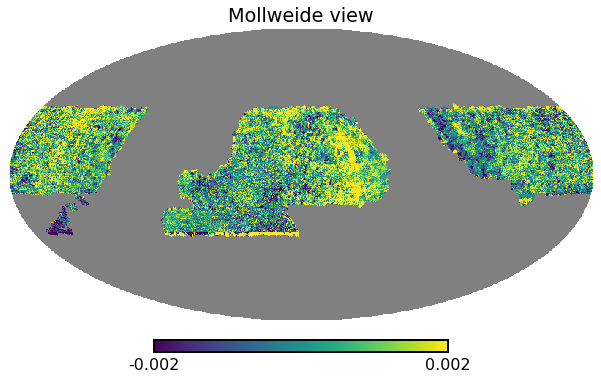

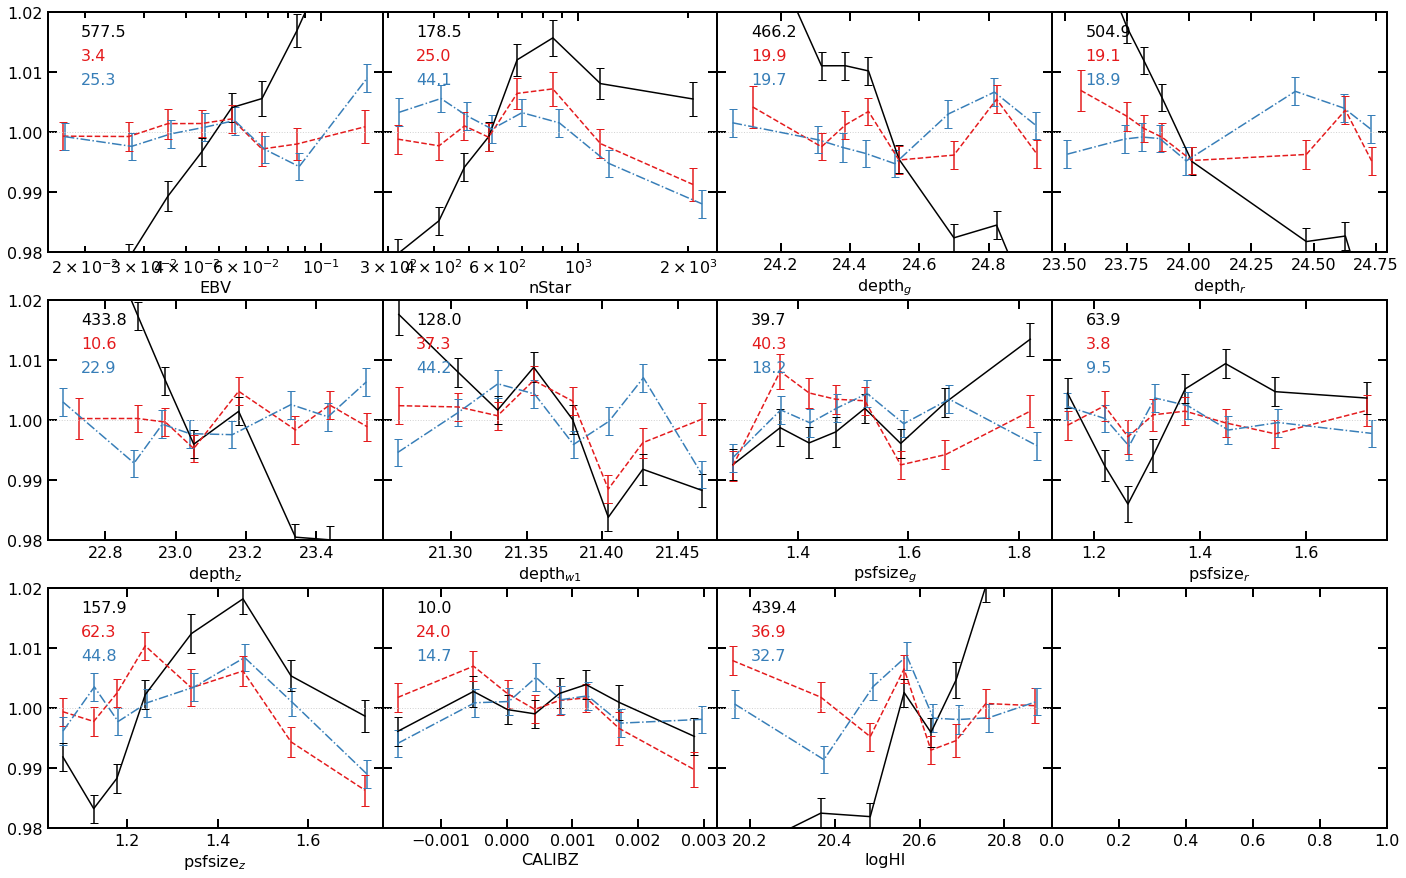

In [32]:
run_calib_test('sdecalsc')

ndecalsc
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.9999185070491402


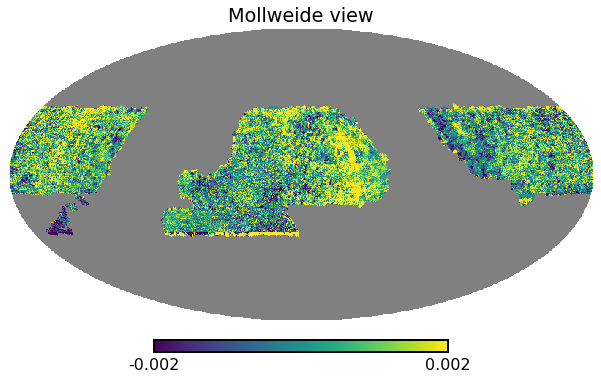

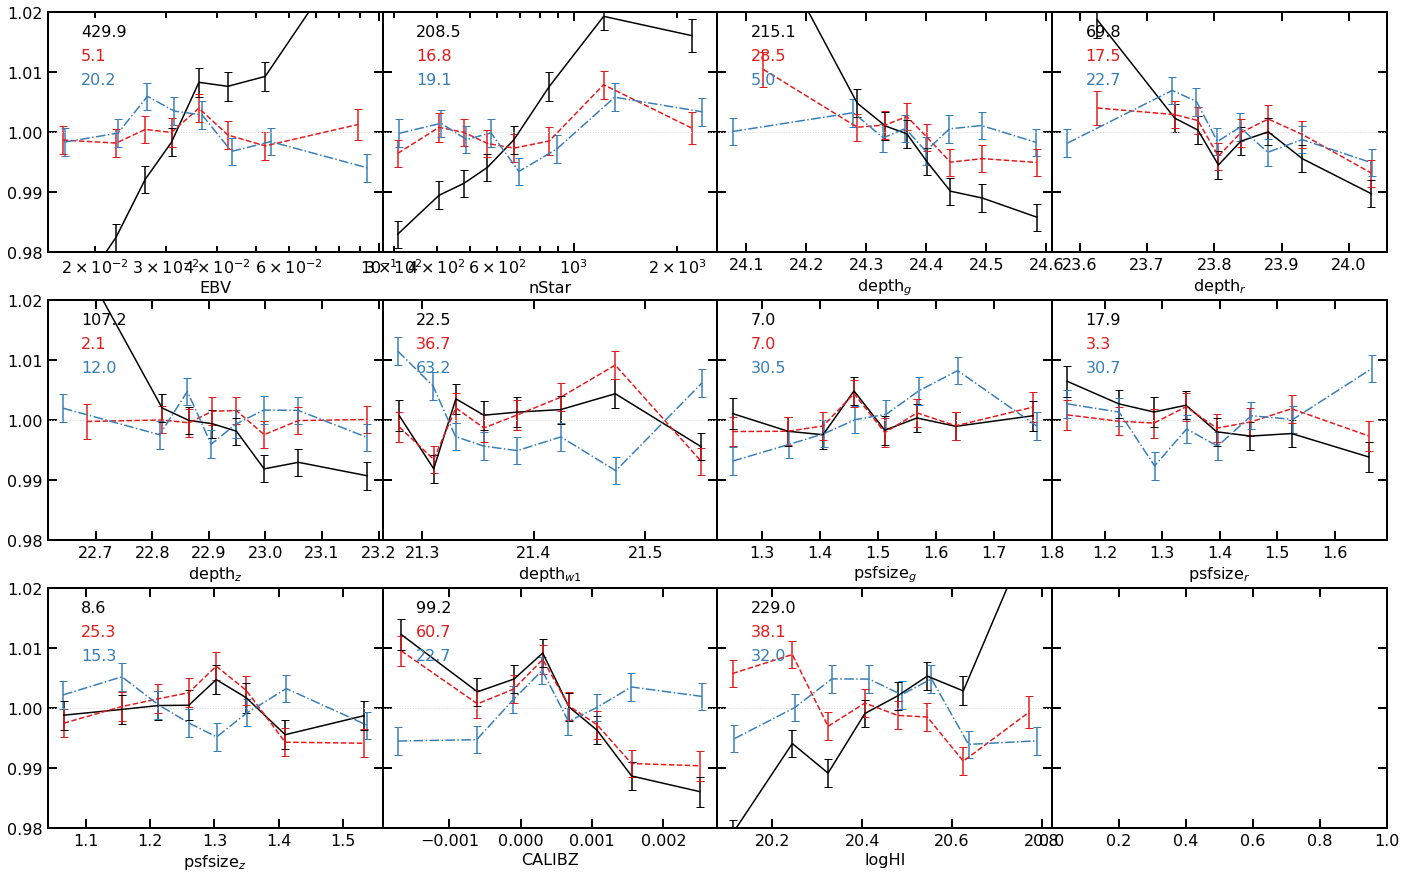

In [33]:
run_calib_test('ndecalsc')

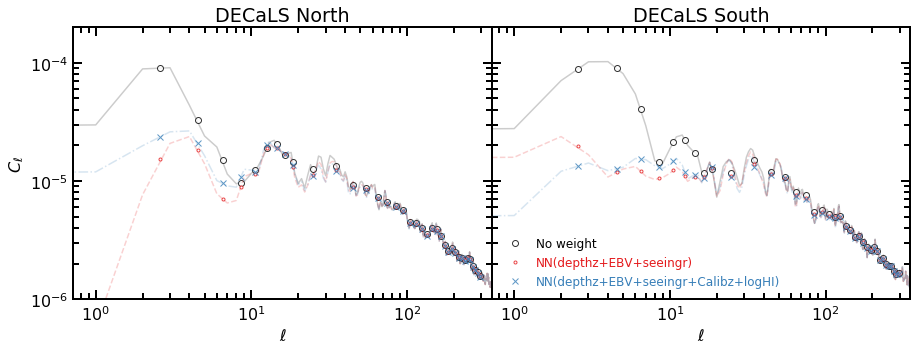

In [48]:
fig, ax = md.plt.subplots(ncols=2, figsize=(15, 5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.0)
mk = ['o', '.', 'x']
lab = ['No weight', 'NN(depthz+EBV+seeingr)', 'NN(depthz+EBV+seeingr+Calibz+logHI)']

for i, m in enumerate(['noweight', 'dnnp_known1', 'dnnp_known1ext']):
    cl = md.np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_ndecalsc_256_{m}.npy', allow_pickle=True).item()    
    lb, clb = md.ut.histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=md.ut.ell_edges)    
    ln, = ax[0].loglog(cl['cl_gg']['cl'], alpha=0.2)
    ax[0].plot(lb, clb, label=lab[i], color=ln.get_color(), alpha=0.8, marker=mk[i], ls='none', mfc='w')
    
    cl = md.np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_sdecalsc_256_{m}.npy', allow_pickle=True).item()    
    lb, clb = md.ut.histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=md.ut.ell_edges)        
    ln, = ax[1].loglog(cl['cl_gg']['cl'], alpha=0.2)
    ax[1].plot(lb, clb, label=lab[i], color=ln.get_color(), alpha=0.8, marker=mk[i], ls='none', mfc='w')


ax[0].set_ylim(1.0e-6, 2.0e-4)
ax[0].set_xlim(xmax=350)
ax[0].set_ylabel(r'$C_{\ell}$')
for a in ax:a.set_xlabel(r'$\ell$')
ax[0].set_title('DECaLS North')
ax[1].set_title('DECaLS South')
lgn = ax[1].legend()
for d, text in enumerate(lgn.get_texts()):
    text.set_color('C%d'%d)

In [13]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = dt['fracgood']
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

In [12]:
ls /fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals*

/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecalsc_dnnp_known1_steps10k_walkers50.npz
/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_dnnp_known1_steps10k_walkers50.npz


No weight 47.06827841846321 1.392588755439644


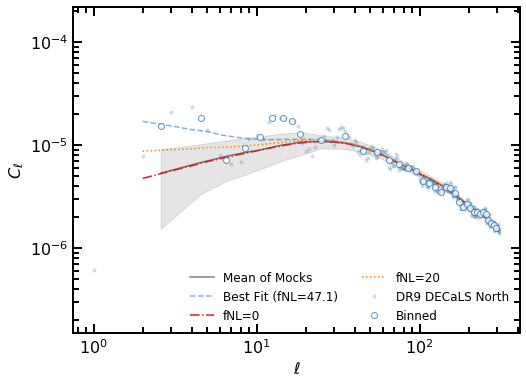

In [14]:
cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_mean.npz')
cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_cov.npz')

cl_err = np.diagonal(cl_cov_['clcov']*1000.)**0.5

el_g = np.arange(300)
plt.figure(figsize=(8, 6))
ln, = plt.plot(cl_['el_bin'], cl_['cl'], label='Mean of Mocks', alpha=0.5)
plt.fill_between(cl_['el_bin'], cl_['cl']-cl_err, cl_['cl']+cl_err, alpha=0.1, color=ln.get_color())

n = 'dnnp_known1'
cl_d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_ndecals_256_{n}.npy', allow_pickle=True).item()
cl_b = ut.histogram_cell(cl_d['cl_gg']['l'], cl_d['cl_gg']['cl'], bins=ut.ell_edges)[1]

bestp = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_{n}_steps10k_walkers50.npz')
fnl, b, noise = bestp['best_fit']
print(nm, fnl, b)

plt.plot(el_g[2:], model(el_g, fnl=fnl, b=b, noise=noise)[2:], alpha=0.6, label=f'Best Fit (fNL={fnl:.1f})', color='C2')
plt.plot(el_g[2:], model(el_g, fnl=0.0, b=b+0.03, noise=noise)[2:], label='fNL=0', color='C1')
plt.plot(el_g[2:], model(el_g, fnl=20.0, b=b+0.03, noise=noise)[2:], label='fNL=20', color='C3')

plt.plot(cl_d['cl_gg']['cl'][:310], label='DR9 DECaLS North', marker='.', ls='none', alpha=0.2, color='C2')
plt.plot(cl_['el_bin'], cl_b, alpha=0.8,  color='C2', label='Binned', ls='none', marker='o', mfc='w')


    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.5e-7, 2.2e-4)

plt.legend(ncol=2, loc=4)
# plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/cl_obs.pdf', bbox_inches='tight')     

In [11]:
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
hpix = dt['hpix']

In [ ]:
ix = '96'

m0c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1-contaminated.fits')
m100c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1-contaminated.fits')
m0 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1.fits')
m100 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1.fits')



[Text(0, 0.5, 'Ncont/Nfid'), Text(0.5, 0, 'HPIX')]

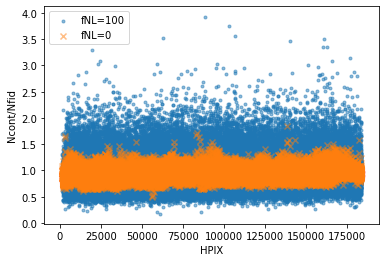

In [31]:

#plt.scatter(m0[hpix], (m0c-m0)[hpix], alpha=0.5)
#plt.scatter(m100[hpix], (m100c-m100)[hpix], alpha=0.5, zorder=-12)
#plt.scatter(m0[hpix], m100[hpix], marker='.', alpha=0.2)

fg, ax = plt.subplots(nrows=1, figsize=(6, 4), sharex=True)

ax.scatter(hpix, m100c[hpix]/m100[hpix], marker='.', alpha=0.5)
ax.scatter(hpix, m0c[hpix]/m0[hpix], marker='x', alpha=0.5)
ax.legend(['fNL=100', 'fNL=0'])
ax.set(xlabel='HPIX', ylabel='Ncont/Nfid')

# ax[1].scatter(hpix, m100c[hpix]-m100[hpix], marker='.', alpha=0.5)
# ax[1].scatter(hpix, m0c[hpix]-m0[hpix], marker='x', alpha=0.5)
# ax[1].legend(['fNL=100', 'fNL=0'])
# ax[1].set(xlabel='HPIX', ylabel='Ncont-Nfid')

In [3]:
from sympy.physics.wigner import wigner_3j
from scipy.optimize import curve_fit

In [4]:
data = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desi_256.fits')
weight = ut.make_hp(256, data['hpix'], data['fracgood'])

0.4856058756510417


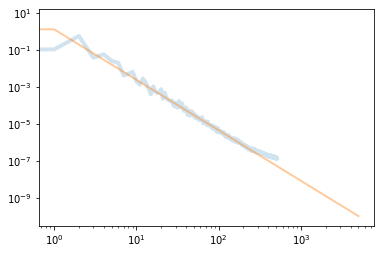

In [58]:
def model(l, *p):
    return p[0]*np.log10(l)+p[1]

def get_cl_wind(weight, mask, plot=False, nside=256):

    fsky = mask.mean()
    print(fsky)
    weight[~mask] = hp.UNSEEN
    cl_wind = hp.anafast(weight, lmax=2*nside) / fsky

    el_p = 1
    el = np.arange(5000)
    is_small = el < el_p

    lmin = 10
    lmax = 200 #2*nside-1
    x = np.arange(lmin, lmax+1)
    y = cl_wind[lmin:lmax+1]
    res = curve_fit(model, x, np.log10(y), p0=[1, 1])

    cl_window = np.zeros(el.size)
    cl_window[:el_p] = cl_wind[:el_p]
    cl_window[~is_small] = 10**model(el[~is_small], *res[0])
    
    if plot:
        x_g = np.arange(el_p, 5000)
        plt.plot(cl_wind, alpha=0.2, lw=4)
        plt.plot(cl_window, alpha=0.4, lw=2, ls='-')
        #plt.plot(x_g, 10**model(x_g, *res[0]), lw=1)
        plt.xscale('log')
        plt.yscale('log')    
        
    return cl_window

mask = weight > 0
cl_w = get_cl_wind(weight, mask, plot=True)

In [59]:
!qstat -u medirz90


o0018.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
20609558             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:59


In [60]:
l1 = np.array([2, 5, 10, 30])
l2 = np.arange(51)
l3 = np.arange(2000)

mixm = np.zeros((l1.size, l2.size))
for i, l1_ in enumerate(l1):
    print('.', end='')
    
    for l2_ in l2:
        l3sum_ = 0.0        
        for l3_ in l3:
            wj = float(wigner_3j(l1_, l2_, l3_, 0, 0, 0))
            l3sum_ += (2.*l3_+1.)*cl_w[l3_]*wj*wj        
        mixm[i, l2_] = l3sum_*(2.*l2_+1.)/(4.*np.pi)

....

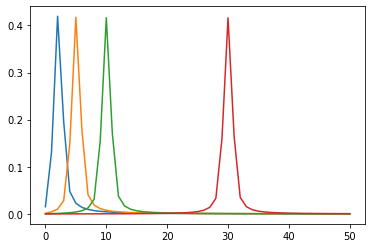

In [61]:
plt.plot(mixm[0, :])
plt.plot(mixm[1, :])
plt.plot(mixm[2, :])
plt.plot(mixm[3, :])
# plt.yscale('log')

22.7  9  2.5
19.6  9  2.2
22.1  9  2.5


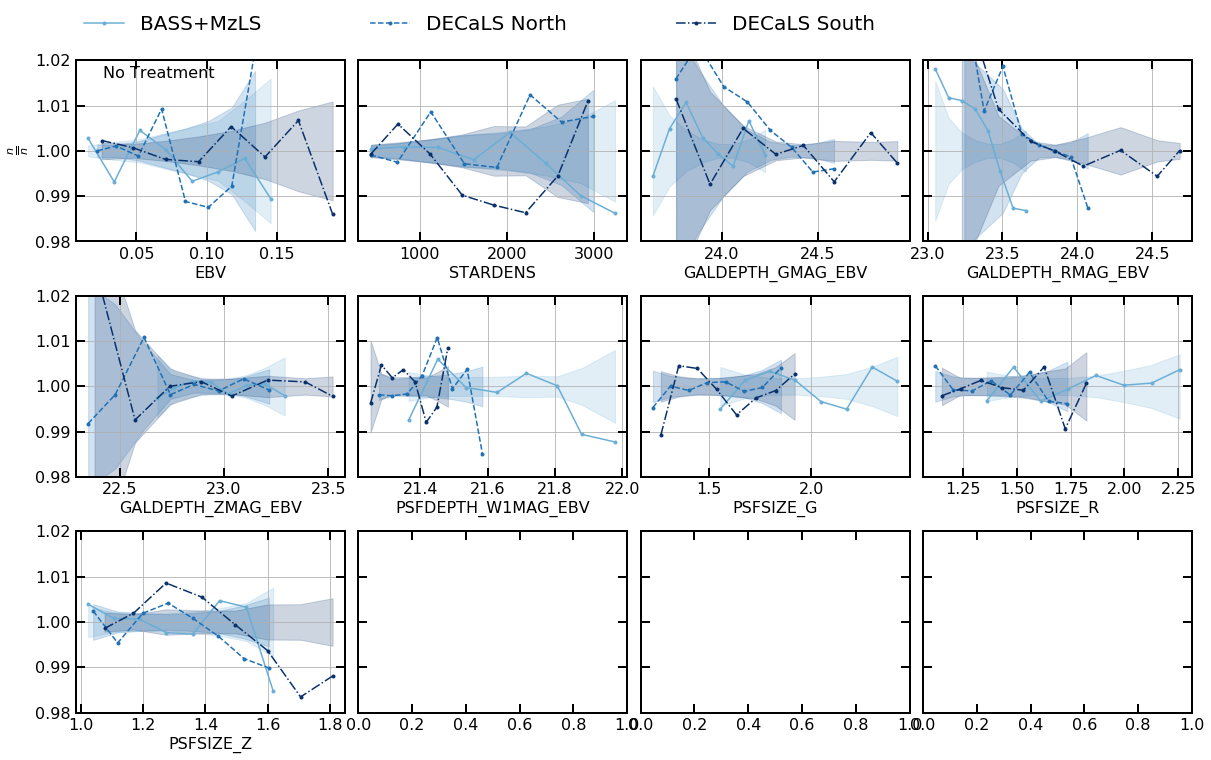

In [19]:
dv.plot_nnbar(['/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_bmzls_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_ndecalsc_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_sdecalsc_256_dnnp_known1.npy'],
            title='No Treatment', axes=np.arange(9), 
            lb=['BASS+MzLS', 'DECaLS North', 'DECaLS South'], 
            ylim=(0.98, 1.02))#, delaxes=[15, 14, 13])

In [ ]:
## combining Obiwon with NN
d = md.ft.read('/fs/ess/PHS0336/data/rongpu/subset_dr9_lrg_sv3_v2.fits')

In [ ]:
for n in d.dtype.names:
    print(n)

In [ ]:
mask_clean = md.np.ones(len(d), dtype=bool)
for bit in [1, 12, 13]:
    mask_clean &= (d['maskbits'] & 2**bit)==0

In [ ]:
dt = md.ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')

In [ ]:
md.np.unique(d['maskbits'])

In [ ]:
dm = d[mask_clean]
d.size, dm.size

In [ ]:
dhp = hpixsum(256, d['ra'], d['dec'])
dhpw = hpixsum(256, d['ra'], d['dec'], weights=d['obiwan_weight'])

In [ ]:
dhp_my = md.make_hp(256, dt['hpix'], dt['label'])

In [ ]:
md.hp.mollview(dhp, rot=120, min=0, max=97, title="Hui's LRGs")

In [ ]:
md.hp.mollview(dhp_my, rot=120, min=0, max=97, title="Rongpu's LRGs")

In [ ]:
def run_rfe(filename):
 
    maps_dr9 = ['ebv', 'nstar']\
                + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
                + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
                + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

    dl = src.MyDataLoader(filename, 
                          do_kfold=True, seed=85)
    axes = []
    for i in range(5):
        fs = src.FeatureElimination(model, dl.load_data(-1, i))
        fs.run([j for j in range(13)])
        axes.append(fs.results['axes_to_keep'])


    #     fs.plot(labels=maps_dr9, cmap='seismic', vmin=0.99, vmax=1.01)
    
    weights = [[(1.+i)/len(axes_i) for i in range(len(axes_i))] for axes_i in axes]

    axes_ = []
    for axi in axes:
        for axj in axi:
            axes_.append(axj)

    weights_ = []
    for wt in weights:
        for wj in wt:
            weights_.append(wj)

    plt.hist(axes_, weights=weights_, bins=np.arange(13), align='left', width=0.8)
    plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)
    plt.xlim(-1, 13)
    plt.ylim(0, 5.2)

In [ ]:
run_rfe('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')

In [ ]:
run_rfe('/fs/ess/PHS0336/data/lognormal/v0/tables/bmzls/nlrg-10-bmzls.fits')

## Fisher

In [ ]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

In [ ]:
cl_ = np.load(path_cl)
el_bin = cl_['el_bin']
el_edges = cl_['el_edges']
cl_cov = np.load(path_cov)
cov = cl_cov['clcov']
cl_cov.files

In [ ]:
noise = 5.24256916e-07
fnl = 0.0
eps = 1.0e-8
el_ = np.arange(el_edges.max()+1)


mp_ = model(el_, fnl+eps, noise=noise)
mn_ = model(el_, fnl-eps, noise=noise)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]
assert np.array_equal(el_b, el_bin)

dcl_f = (mp-mn)/(2*eps)

mp_ = model(el_, fnl=fnl, noise=noise+eps)
mn_ = model(el_, fnl=fnl, noise=noise-eps)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]

dcl_n = (mp-mn)/(2*eps)

In [ ]:
dcl_l = [dcl_f, dcl_n]

icov = np.linalg.inv(cov)
fisher = np.zeros((2, 2))
for i, dcl_i in enumerate(dcl_l):
    for j, dcl_j in enumerate(dcl_l):
        fisher[i, j] = dcl_i.dot(icov.dot(dcl_j))
fisher

In [ ]:
ifisher = np.linalg.inv(fisher)
ifisher

In [ ]:
pdf = lambda x, mu, sig:np.exp(-0.5*(x-mu)**2/sig**2)/np.sqrt(2.*np.pi*sig**2)

In [ ]:
from scipy.stats import norm

In [ ]:
sig = np.sqrt(ifisher[0, 0])
print(sig)
fnl_g = np.linspace(-200, 200, 200)
plt.plot(fnl_g, pdf(fnl_g, 0.0, sig))

In [ ]:
nmocks = 1000
nbins = 17
hf_b = (nmocks - 1.0)/(nmocks - nbins - 2.0)

fisher = []
for i, lmin in enumerate(el_bin[:7]):
    print(i, lmin)

    hf_a = (nmocks - 1.0)/(nmocks - (nbins-i) - 2.0)
    
    cov_i = cov[i:, i:]/(hf_b)*hf_a
    
    icov_i = np.linalg.inv(cov_i)
    
    fisher.append((lmin, dcl_f[i:].dot(icov_i.dot(dcl_f[i:]))))
    
fisher = np.array(fisher)
plt.plot(fisher[:, 0], fisher[:, 1])

In [ ]:
noise = 5.24256916e-07
el_ = np.arange(0, 100).astype('int')
fnl = 0.0
for eps in [1.0e-8, ]:
    print(fnl+eps, fnl-eps)
    m_p = model(el_, fnl=fnl+eps, noise=noise)
    m_n = model(el_, fnl=fnl-eps, noise=noise)
    plt.plot(el_, 1.0e8*(m_p-m_n)/(2*eps)), #label='eps = %3.e'%eps)
    
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.title(r'$10^{8}~\partial C_{\ell} / \partial f_{\rm NL}$')
# plt.legend(loc='upper right', fontsize=15)
# plt.savefig('dClfnl.png', dpi=300, bbox_inches='tight')

In [ ]:
fisher2 = []
for i, lmax in enumerate(el_bin[-3:]):
    ix = -3+i
    print(i, ix, lmax)
    cov_i = cov[:ix, :ix]*()*()
    icov_i = np.linalg.inv(cov_i)
    fisher2.append((lmax, dcl[:ix].dot(icov_i.dot(dcl[:ix]))))
    
fisher2 = np.array(fisher2)

In [ ]:
plt.plot(fisher[:, 0], fisher[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm min}$')
plt.ylabel(r'F$_{11}$')
plt.xlim(0., 70.)

In [ ]:
plt.plot(fisher2[:, 0], fisher2[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'F$_{11}$')
# plt.xlim(0., 70.)